# Model training 
First iteration of model training 

Packages 

In [2]:
#Change working directory to project direcgtory
import os

current_directory = os.getcwd()
project_name = 'bcppmchurn'
project_path = os.path.join(current_directory.split(project_name)[0], project_name)
os.chdir(project_path)
print(os.getcwd())  

/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
#from xgboost.callback import reset_learning_rate
import pickle 
import json

from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [4]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

In [5]:
#Reload modules in case a change has occured
#import importlib
#from src.components import data_ingestion, data_structuring
#importlib.reload(data_ingestion)
#importlib.reload(data_structuring)

### Loding data

--------------------

In [7]:
#Loading data
data_date = "2024-11-28"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

x_train shape : (134460, 531)
y_train shape : (134460, 1)
------------------
x_dev shape : (13550, 531)
y_dev shape : (13550, 1)
------------------
x_test shape : (5416, 531)
y_test shape : (5416, 1)


In [9]:
#target value_counts
print ("y_train counts")
print (y_train.value_counts())
print ("-------------")
print ("y_dev counts")
print (y_dev.value_counts())
print ("-------------")
print ("y_test counts")
print (y_test.value_counts())

y_train counts
churn
0        69340
1        65120
Name: count, dtype: int64
-------------
y_dev counts
churn
0        7055
1        6495
Name: count, dtype: int64
-------------
y_test counts
churn
0        2774
1        2642
Name: count, dtype: int64


In [10]:
#transform y to array
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()
print (f"y_train length : {len(y_train)}")
print (f"y_dev length : {len(y_dev)}")
print (f"y_test length : {len(y_test)}")

y_train length : 134460
y_dev length : 13550
y_test length : 5416


-------------------

### Model training 

#### XGBoost

In [64]:
#Data to DMatrix
dtrain = xgb.DMatrix(data=x_train, label=y_train)
ddev = xgb.DMatrix(data=x_dev, label=y_dev)
dtest = xgb.DMatrix(data=x_test, label=y_test)
evals = [(dtrain, "train"), (ddev, "dev")]

In [66]:
#Model parameters 
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',       
    'eta': 0.1,                     
    'max_depth': 5,                  
    'subsample': 0.9,                 
    'colsample_bytree': 1,           
    'min_child_weight': 1,            
    'gamma': 0.1,                     
    'scale_pos_weight': 1,                        
    'learning_rate': 0.01
}

In [67]:
#Trianing model
eval_hist = {}
XGB_MODEL = None
XGB_MODEL = xgb.train( params = params,
                        dtrain=dtrain,
                        num_boost_round=10000,
                        evals=evals,
                        evals_result=eval_hist,
                        early_stopping_rounds=50,  #Stop early if no improvement
                        verbose_eval=True
                    )

[0]	train-logloss:0.68738	dev-logloss:0.68710
[1]	train-logloss:0.68222	dev-logloss:0.68197
[2]	train-logloss:0.67716	dev-logloss:0.67694
[3]	train-logloss:0.67220	dev-logloss:0.67202
[4]	train-logloss:0.66734	dev-logloss:0.66718
[5]	train-logloss:0.66256	dev-logloss:0.66244
[6]	train-logloss:0.65789	dev-logloss:0.65778
[7]	train-logloss:0.65330	dev-logloss:0.65322
[8]	train-logloss:0.64880	dev-logloss:0.64873
[9]	train-logloss:0.64437	dev-logloss:0.64433
[10]	train-logloss:0.64004	dev-logloss:0.64002
[11]	train-logloss:0.63578	dev-logloss:0.63580
[12]	train-logloss:0.63160	dev-logloss:0.63163
[13]	train-logloss:0.62751	dev-logloss:0.62756
[14]	train-logloss:0.62346	dev-logloss:0.62353
[15]	train-logloss:0.61951	dev-logloss:0.61960
[16]	train-logloss:0.61561	dev-logloss:0.61572
[17]	train-logloss:0.61178	dev-logloss:0.61191
[18]	train-logloss:0.60804	dev-logloss:0.60818
[19]	train-logloss:0.60434	dev-logloss:0.60451
[20]	train-logloss:0.60073	dev-logloss:0.60091
[21]	train-logloss:0.59

#### Model Performances

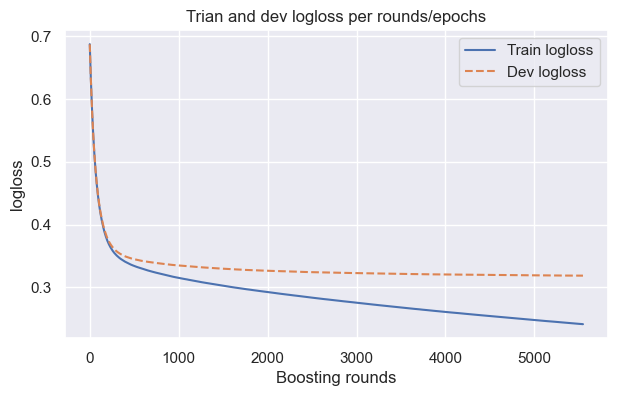

In [68]:
#Plot log loss
utils.vis_training_metric(eval_hist, eval_metric="logloss")

In [69]:
#Predictions
y_test_predicted_prob = XGB_MODEL.predict(dtest)
y_train_predicted_prob = XGB_MODEL.predict(dtrain)
#Transform probas into predictions
THRESHOLD = 0.35
y_test_pred = [int(y_test_predicted_prob[i]>THRESHOLD) for i in range(len(y_test_predicted_prob))]
y_train_pred = [int(y_train_predicted_prob[i]>THRESHOLD) for i in range(len(y_train_predicted_prob))]

                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.9085081065000744  ||  0.8683530280649926
xgboost precision   : 0.901511235442576  ||  0.8677087304613038
xgboost recall      : 0.9105651105651106  ||  0.8614685844057532
xgboost f1 score    : 0.9060155545708741  ||  0.8645773979107313
-------------------------------------------------------------


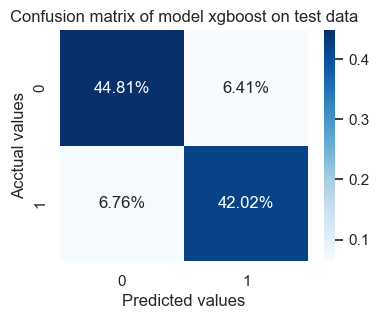

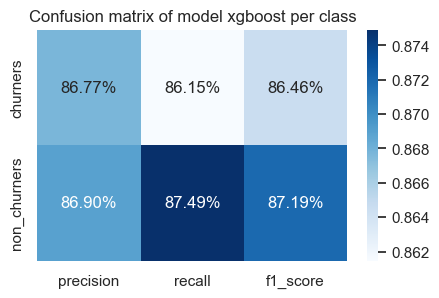

In [70]:
#Visualize model performance
utils.report_model_performances(y_train, y_train_pred, y_test, y_test_pred, model_name = "xgboost")

#### Model calibration 

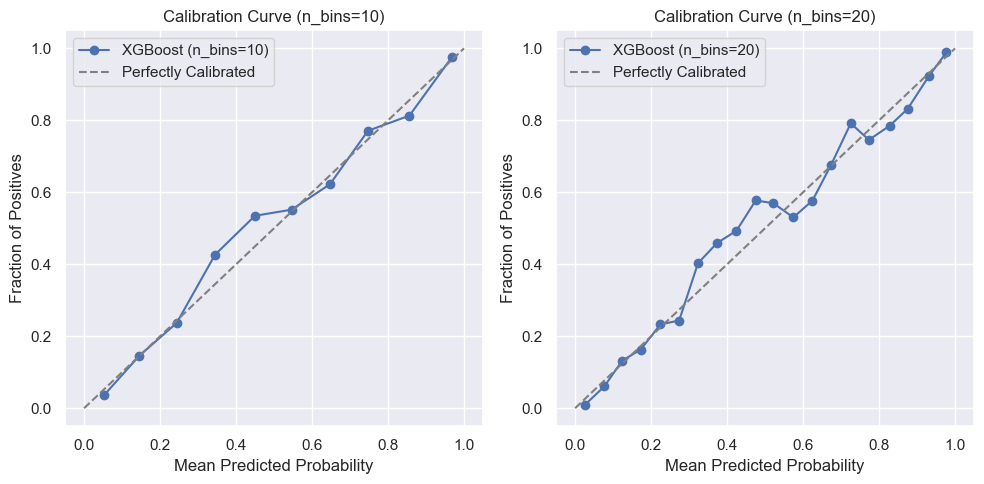

In [71]:
#Plot calibration curve 
utils.vis_calibration_curve(n_bins=[10, 20], y_test=y_test, y_test_predicted_prob=y_test_predicted_prob)

#### ROC curve 

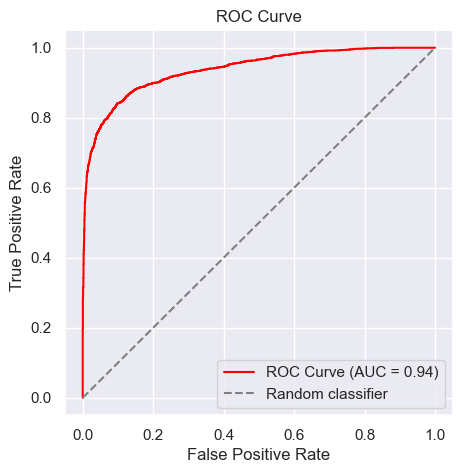

In [73]:
#Plot roc curve 
utils.vis_roc_curve(y_test, y_test_predicted_prob)

#### Feature importance 

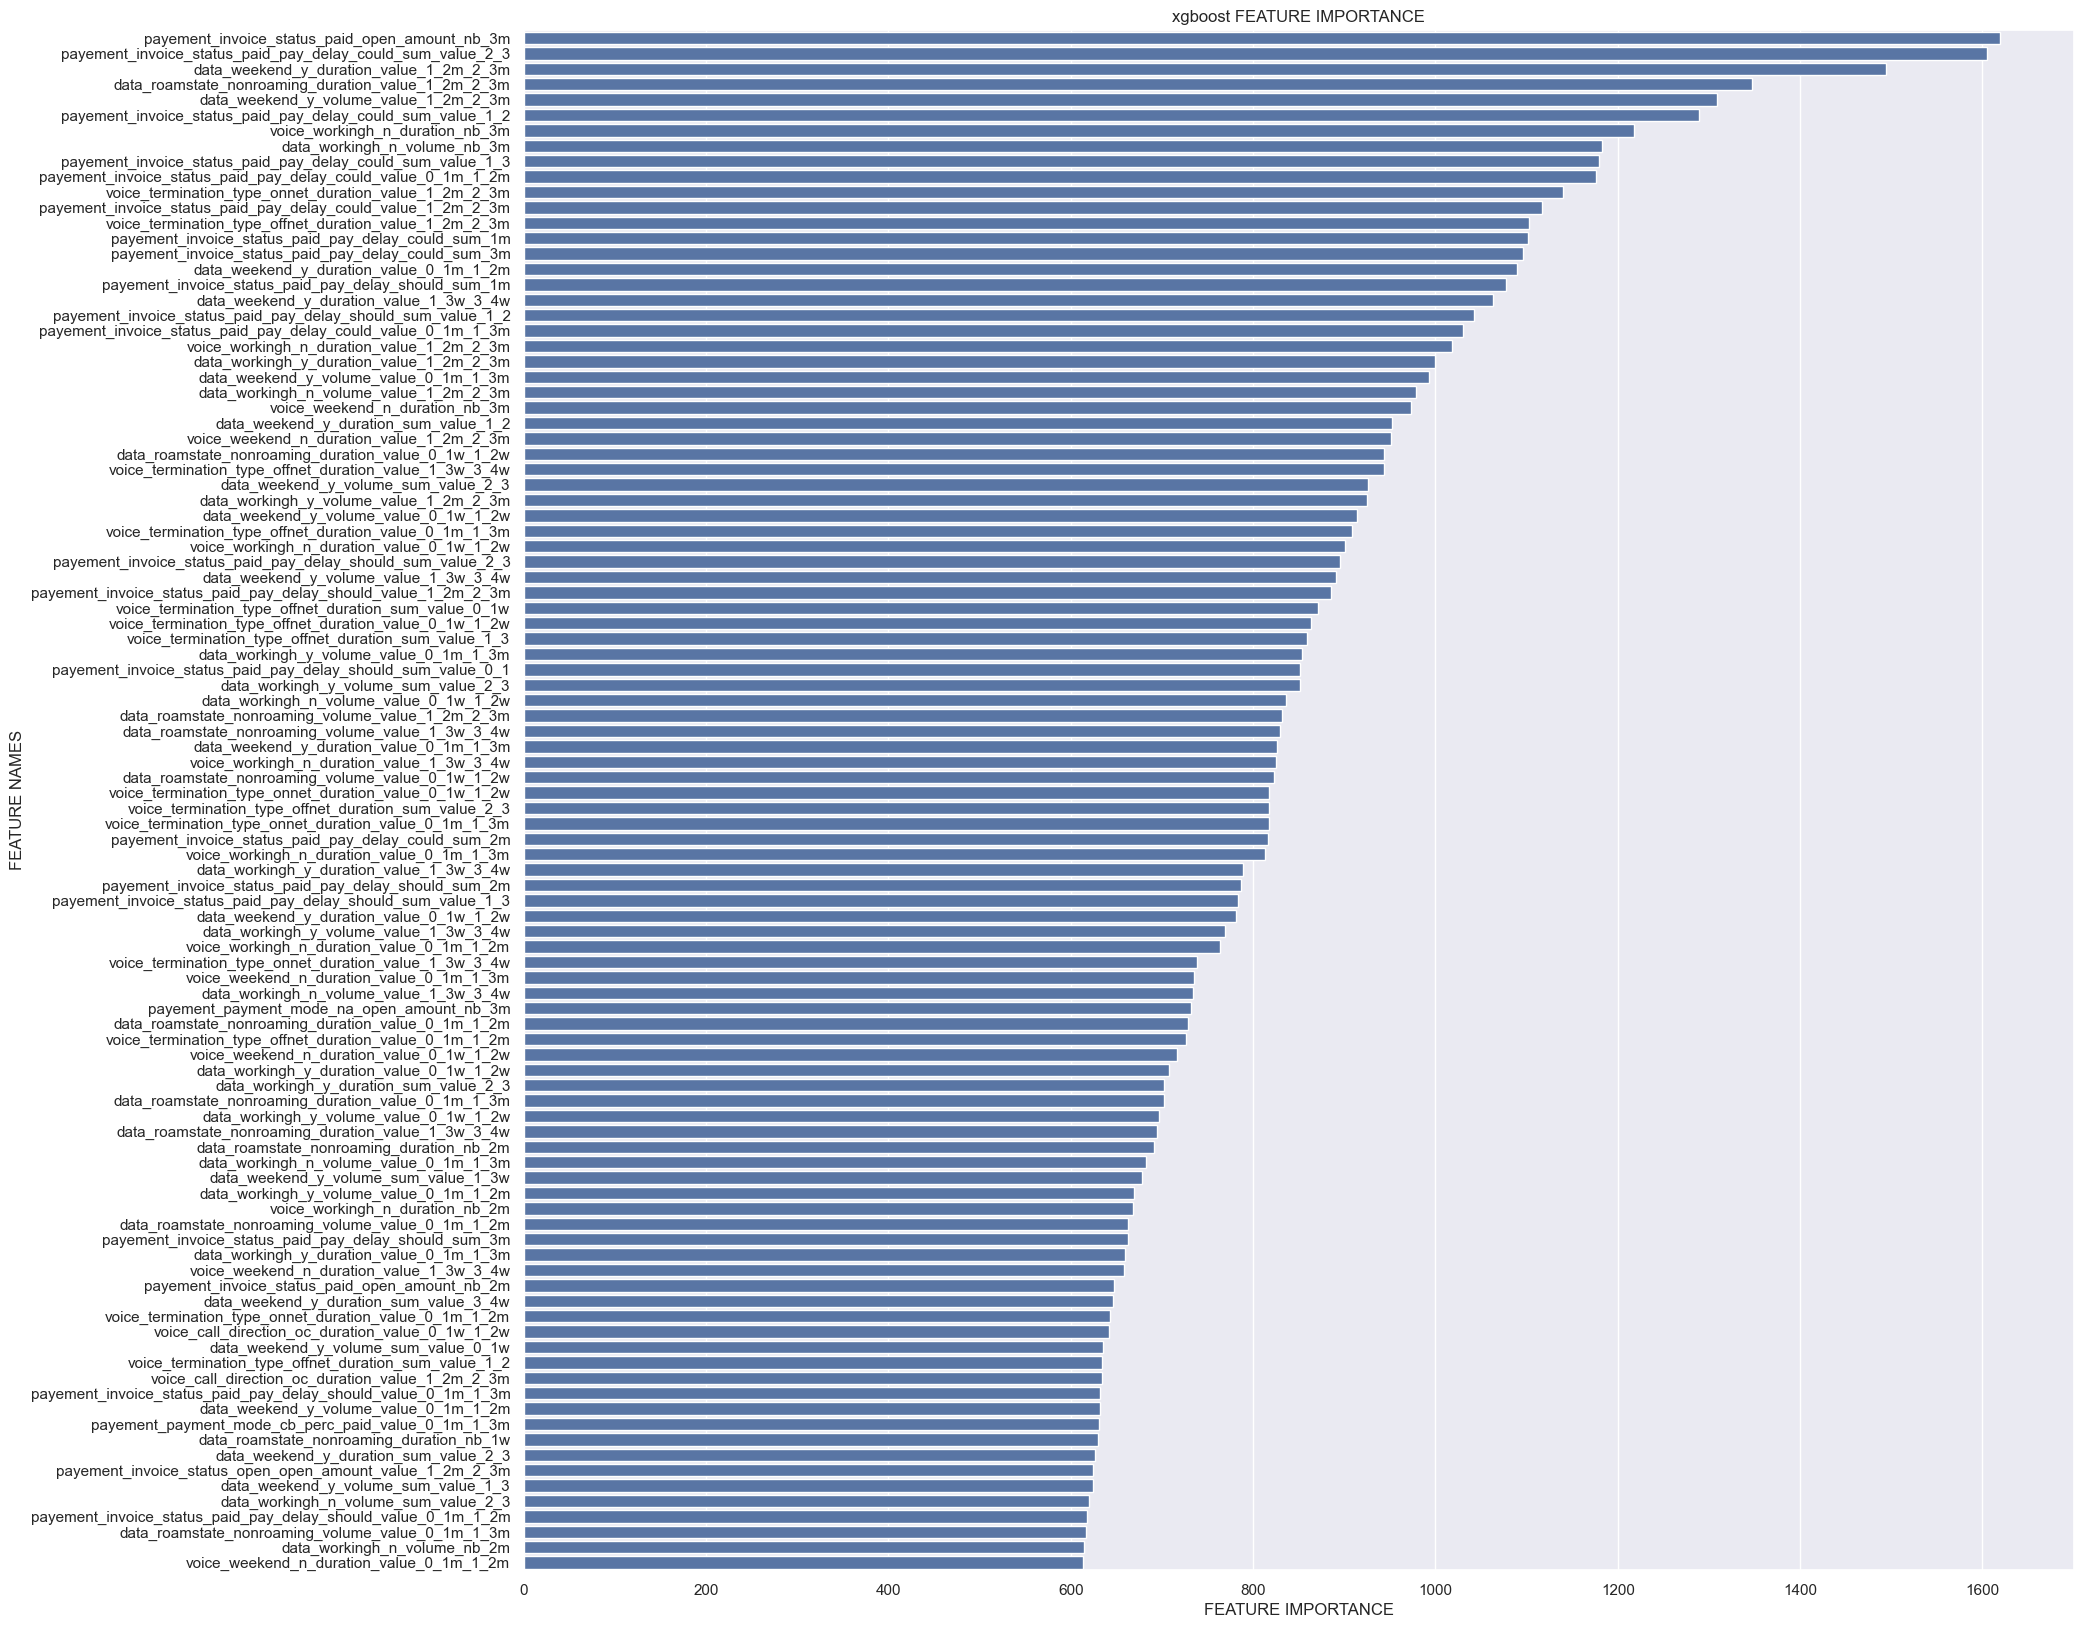

In [74]:
#Get feature importance from model
importance =  XGB_MODEL.get_score(importance_type = "weight")
#Plot importance
utils.plot_feature_importance(importance.values(), importance.keys(), model_type="xgboost", max_n_features=100, figsize=(20, 20))

#### Actual points and predicted points density

Applying tsne on data
Ploting data distribution


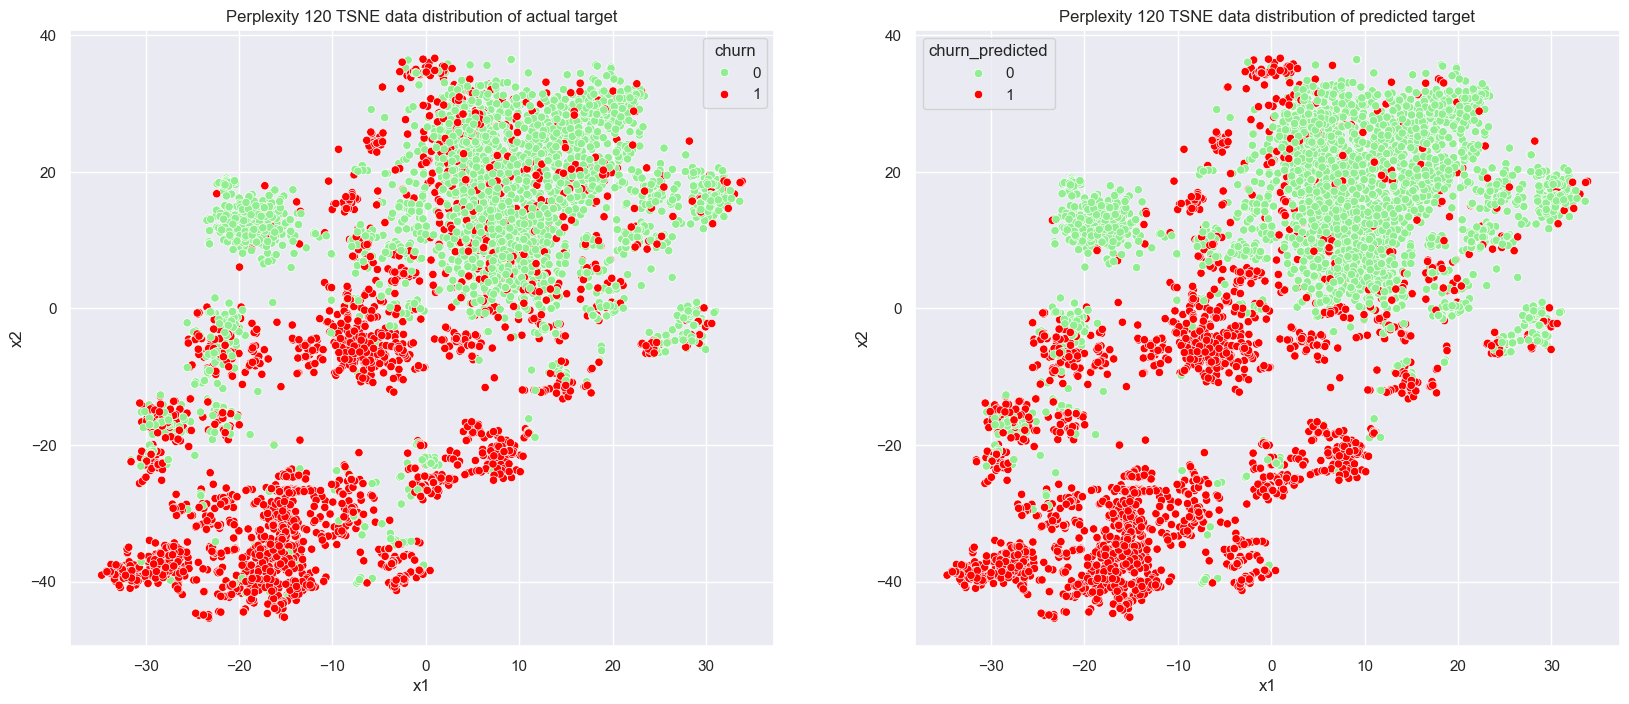

In [75]:
#Apply tsne for data distribution visualization
utils.vis_data_distribution_of_acctual_and_predicted_target_with_tsne(x_test, y_test, y_test_pred)

#### Count of correct and wrong scores 

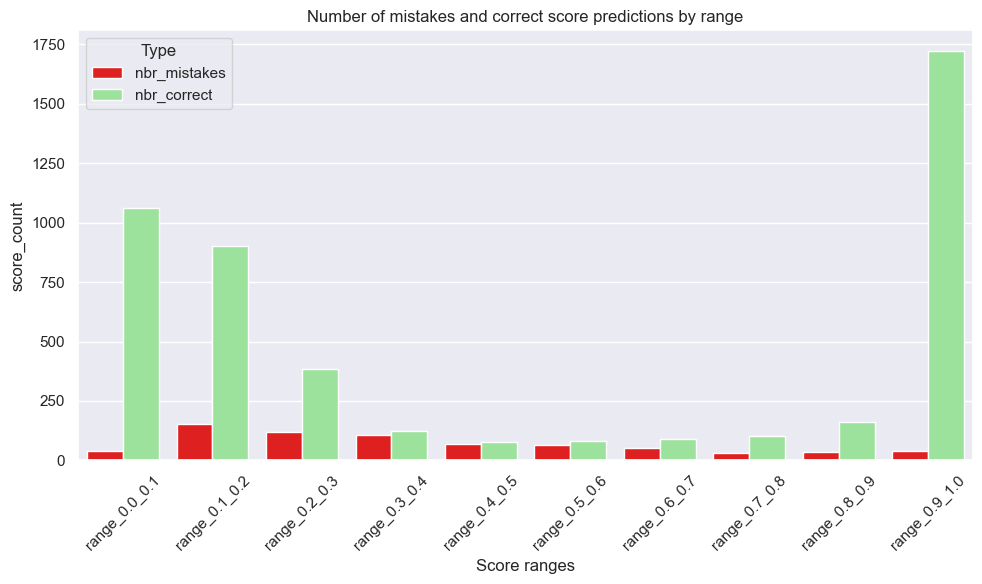

In [77]:
utils.vis_count_mistakes_and_correct_scores(y_test, y_test_pred, y_test_predicted_prob)

#### Precision recall per thereshold values

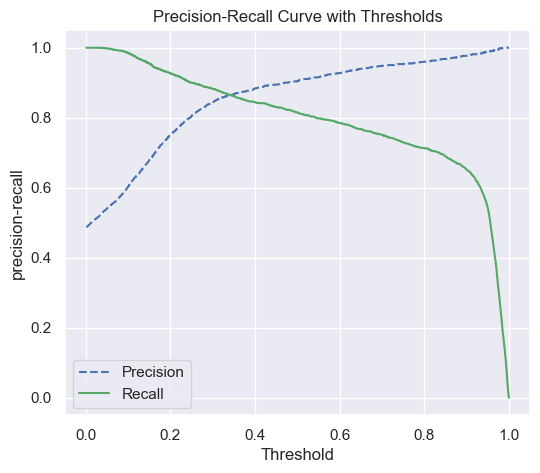

In [79]:
#Precision recall curve
utils.vis_precision_recall_thereshold(y_test, y_test_predicted_prob)

#### Save model 

In [80]:
#Save model as pickle file 
pickle.dump(XGB_MODEL, open(f"{models_path}/{date_time}_xgb_model_iter2.pkl", "wb"))

In [81]:
#Save model as json file
XGB_MODEL.save_model(f"{models_path}/{date_time}_xgb_model_iter2.json")

In [82]:
#Save model feature names
inference_feature_names = XGB_MODEL.feature_names
with open(f"{models_ressources_path}/{date_time}_inference_feature_names_iter2.txt", "w") as f:
    f.write(str(inference_feature_names))

In [342]:
#Load model
#with open(f"{models_path}/2024-10-25_xgb_model.pkl", "rb") as f:
#    t_model = pickle.load(f)

### Best Resutls History 

params_2 = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',       
    'eta': 0.1,                     
    'max_depth': 5,                  
    'subsample': 0.9,                 
    'colsample_bytree': 1,           
    'min_child_weight': 1,            
    'gamma': 0.1,                     
    'scale_pos_weight': 1,                        
    'learning_rate': 0.01
}
num_boost_round=10000,
early_stopping_rounds=50

                            train set     ||     test set

xgboost accuracy    : 0.733988            ||  0.7139

xgboost precision   : 0.6651191616429094  ||  0.6531800113571834

xgboost recall      : 0.9435328532493586  ||  0.9167164773859334

xgboost f1 score    : 0.7802331076280457  ||  0.7628284837934179

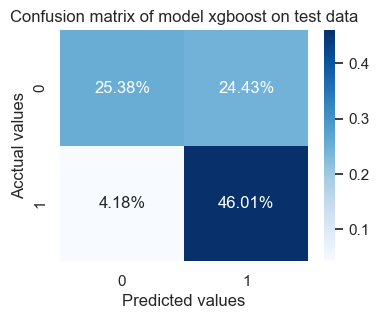

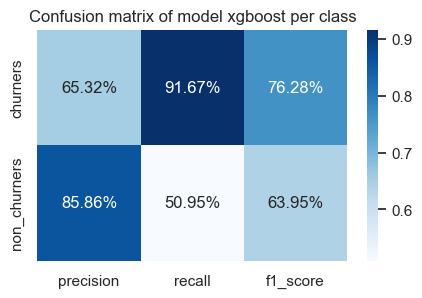

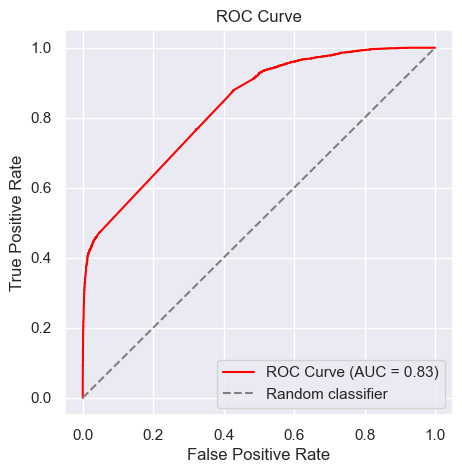

### Combination of models 

In [45]:
with open("models/ml_models/2024-10-25_xgb_model.pkl", "rb") as f:
    XGB_MODEL_ITER1 = pickle.load(f)

In [81]:
#Predictions
y_test_predicted_prob_iter1 = XGB_MODEL_ITER1.predict(dtest)
y_train_predicted_prob_iter1 = XGB_MODEL_ITER1.predict(dtrain)
y_test_predicted_prob_iter2 = XGB_MODEL.predict(dtest)
y_train_predicted_prob_iter2 = XGB_MODEL.predict(dtrain)

p_iter1 = 0.1
p_iter2 = 0.9

y_test_predicted_prob_combination = (p_iter1*y_test_predicted_prob_iter1 + p_iter2*y_test_predicted_prob_iter2)
y_train_predicted_prob_combination  = (p_iter1*y_train_predicted_prob_iter1 + p_iter2*y_train_predicted_prob_iter2)

In [78]:
print (y_test_predicted_prob_iter2)
print (y_test_predicted_prob_iter1)
print (y_test_predicted_prob_combination)

[0.751505  0.9788703 0.4343752 ... 0.4343752 0.956515  0.9588974]
[0.61998343 0.09598386 0.05088544 ... 0.05088544 0.8077684  0.03797835]
[0.6988964  0.62571573 0.2809793  ... 0.2809793  0.8970164  0.5905298 ]


In [ ]:
#Transform probas into predictions
THRESHOLD = 0.3
y_test_pred_combination = [int(y_test_predicted_prob_combination[i]>THRESHOLD) for i in range(len(y_test_predicted_prob_combination))]
y_train_pred_combination = [int(y_train_predicted_prob_combination[i]>THRESHOLD) for i in range(len(y_train_predicted_prob_combination))]

                  train set      ||     test set
------------------------------------------------------------
 accuracy    : 0.743832  ||  0.7109
 precision   : 0.6678447171854303  ||  0.6476957245974458
 recall      : 0.9711470064020077  ||  0.9296672643952979
 f1 score    : 0.7914321817518628  ||  0.7634786877198724
-------------------------------------------------------------


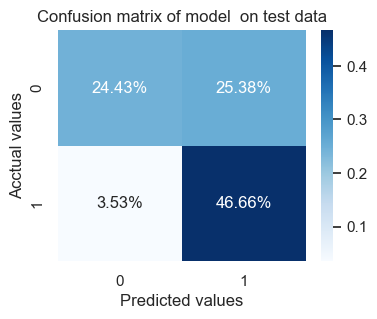

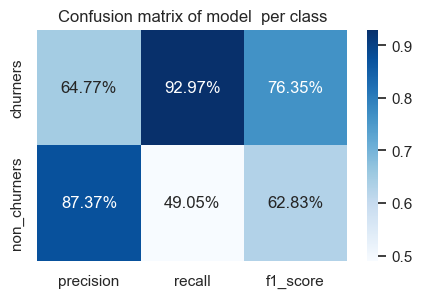

In [83]:
utils.report_model_performances(y_train, y_train_pred_combination, y_test, y_test_pred_combination)

In [71]:
from sklearn.metrics import f1_score, precision_score, recall_score
# Plages de recherche
p_range = np.linspace(0, 1, 11)  # Par exemple, 0.0, 0.1, ..., 1.0
threshold_range = np.linspace(0, 1, 11)  # Par exemple, 0.0, 0.1, ..., 1.0

best_params = None
best_f1 = 0

# Boucle sur les combinaisons de p_iter1 et THRESHOLD
for p_iter1 in p_range:
    p_iter2 = 1 - p_iter1  # Respecter la contrainte
    for threshold in threshold_range:
        # Combinaison des probabilités
        y_test_predicted_prob_combination = (
            p_iter1 * y_test_predicted_prob_iter1 + p_iter2 * y_test_predicted_prob_iter2
        )
        y_train_predicted_prob_combination = (
            p_iter1 * y_train_predicted_prob_iter1 + p_iter2 * y_train_predicted_prob_iter2
        )

        # Transformation en prédictions
        y_test_pred_combination = [
            int(prob > threshold) for prob in y_test_predicted_prob_combination
        ]
        y_train_pred_combination = [
            int(prob > threshold) for prob in y_train_predicted_prob_combination
        ]

        # Calcul des métriques
        f1 = f1_score(y_test, y_test_pred_combination)
        precision = precision_score(y_test, y_test_pred_combination)
        recall = recall_score(y_test, y_test_pred_combination)

        # Mise à jour des meilleurs paramètres si F1 est meilleur
        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                "p_iter1": p_iter1,
                "p_iter2": p_iter2,
                "THRESHOLD": threshold,
                "F1": f1,
                "Precision": precision,
                "Recall": recall,
            }

# Résultats
print("Meilleurs paramètres trouvés :")
print(best_params)


/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

Meilleurs paramètres trouvés :
{'p_iter1': np.float64(0.1), 'p_iter2': np.float64(0.9), 'THRESHOLD': np.float64(0.30000000000000004), 'F1': np.float64(0.7634786877198724), 'Precision': np.float64(0.6476957245974458), 'Recall': np.float64(0.9296672643952979)}


/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  train set      ||     test set
------------------------------------------------------------
 accuracy    : 0.628592  ||  0.6316
 precision   : 0.7933875279611544  ||  0.8063331803579624
 recall      : 0.3486816339905848  ||  0.3500697350069735
 f1 score    : 0.4844534269088971  ||  0.4881911642122812
-------------------------------------------------------------


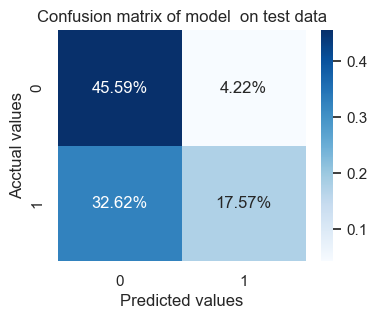

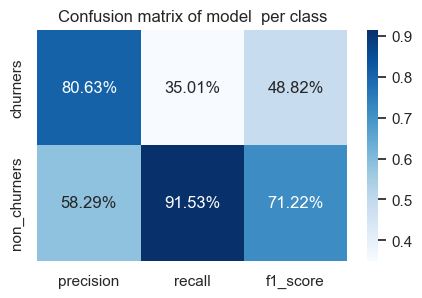

In [131]:
#Transform probas into predictions
THRESHOLD = 0.2
y_test_pred_iter1 = [int(y_test_predicted_prob_iter1[i]>THRESHOLD) for i in range(len(y_test_predicted_prob_iter1))]
y_train_pred_iter1 = [int(y_train_predicted_prob_iter1[i]>THRESHOLD) for i in range(len(y_train_predicted_prob_iter1))]

utils.report_model_performances(y_train, y_train_pred_iter1, y_test, y_test_pred_iter1)

#### Further training iter1 model on churners 